# Latent Dirichlet Allocation (LDA)

* https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
* [Probabilistic Topic Models - Surveying a suite of algorithms that offer a solution to managing large document archives -  David M. Blei](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)
    * Review article giving high level overview
* [Probabilistic Topic Models - Mark Steyvers, Tom Griffiths](http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf)
    * Describes Gibbs sampling approach
* [Finding scientific topics - Thomas L. Griffiths,Mark Steyvers](http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf)
    * Describes Gibbs sampling approach
* [Gibbs Sampler for LDA](https://wiseodd.github.io/techblog/2017/09/07/lda-gibbs/)
    * [code](https://github.com/wiseodd/probabilistic-models/tree/master/models/bayesian)
* [Parameter estimation for text analysis](http://www.arbylon.net/publications/text-est.pdf)
* Machine Learning: Clustering & Retrieval ([Coursera course](https://www.coursera.org/learn/ml-clustering-and-retrieval/home/welcome)). Week 5: Mixed Membership Modeling via Latent Dirichlet Allocation

In [1]:
%matplotlib inline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
EPS=1e-6

## Probabilistic Topic Models

* Documents are mixtures of topics. Each document has a distribution $P(z)$ over topics $z$.
* A topic is a probability distribution over words. The conditional distribution for a word $w$ given topic $z$ is denoted as $P(w \mid z)$.

This means that the distribution of word $w$ within a document can be written as:

$$
P(w) = \sum^{K}_{k=1} P(w \mid z = k) P(z = k)
$$

## Generative process

Given:
* $\alpha$ the prior on the Dirichtlet distribution modelling the document topic distributions. $\alpha$ is a vector of size $K$ the number of topics.
* $\beta$ the prior on the Diricthlet distribution modelling the topic word distribution. $\beta$ is a vector of size $W$ the vocabulary of possible words.

We can generate bag-of-word document samples by:

1. For each document $i \in \{1,\ldots, D \}$ sample the topic distribution $\theta_{i}\sim \operatorname{Dir}(\alpha)$
2. For each topic $k \in \{1, \ldots, K \}$ sample the word distribution $\varphi_{k}\sim \operatorname {Dir}(\beta)$
3. Generate the words in a two-stage process: For each document $i$ and each word $j$ from that document:
    1. Sample a topic $z_{i,j}\sim \operatorname{Categorical} (\theta_{i})$
    2. Sample a word from that topic $w_{i,j} \sim \operatorname{Categorical} (\varphi_{z_{i,j}})$

In [3]:
np.random.seed(42)

n_topics = 2
n_words_vocab = 5
n_documents = 20

# Topic distribution 𝜃 for each document
doc_topic_dist = np.zeros((n_documents, n_topics))
doc_topic_dist[:n_documents//2, 0] = 1
doc_topic_dist[n_documents//2:, 1] = 1
# Word distribution 𝜑 for each topic
topic_word_dist = np.array([
    [1/3, 1/3, 1/3,  0.,  0.],
    [0.,  0.,  1/3,  1/3, 1/3]])

# Generate sample of documents
documents_words = []  # Words in documents
documents_word_topics = []  # Topic assignment for words in document
for doc_idx in range(n_documents):
    # Sample number of words in document by Poisson distribution
    n_words_doc = int(1 + np.random.poisson(lam=4., size=1))
    doc_topics = np.random.choice(
        a=n_topics, p=doc_topic_dist[doc_idx,:], size=n_words_doc)
    doc_words = [
        np.random.choice(
            a=n_words_vocab, 
            p=topic_word_dist[doc_topics[word_idx], :])
        for word_idx in range(n_words_doc)]
    documents_word_topics.append(doc_topics.tolist())
    documents_words.append(doc_words)

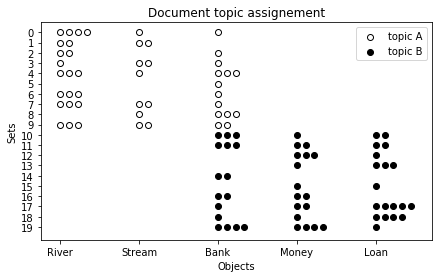

In [4]:
def plot_topic_assignment(
        doc_word_assignment, 
        doc_word_topic_assignment,
        title):
    max_doc_len = max(map(len, doc_word_assignment))
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    for doc_idx in range(n_documents):
        word_plotted_count = np.zeros((n_words_vocab, ))
        for doc_word_idx, word in enumerate(doc_word_assignment[doc_idx]):
            topic_idx = doc_word_topic_assignment[doc_idx][doc_word_idx]
            shift = word_plotted_count[word] / max_doc_len
            if topic_idx == 0:
                ax.scatter(
                    [word + shift], [doc_idx], 
                    marker='o', c='w', edgecolors='k', label='topic A')
            if topic_idx == 1:
                ax.scatter(
                    [word + shift], [doc_idx], 
                    marker='o', c='k', edgecolors='k', label='topic B')
            word_plotted_count[word] += 1
    ax.set_yticks(np.arange(n_documents))
    ax.invert_yaxis()
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(('River', 'Stream', 'Bank', 'Money', 'Loan'))
    ax.set_ylabel('Sets')
    ax.set_xlabel('Objects')
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    plt.show()


plot_topic_assignment(documents_words, documents_word_topics, 'Document topic assignement')

## Gibbs sampling

Gibbs sampling will iteratively randomly sample topic assignments to each word in the corpus.

The probability of assigning word $w$ to topic $z = k$ is:

$$
P(z = k \mid w) = \frac{P(w \mid z=k) P(z=k)}{P(w)}
$$

Which for each document $i$ word $w_{i,j}$ and topic $k$ becomes:
$$
P(z_i = k \mid w_{i,j})  = \frac{\theta_{i,k} \varphi_{w_{i,j},k}}{\sum^{K}_{t=1} \theta_{i,t} \varphi_{w_{i,j},t}}
$$

In regular Gibbs sampling the following steps are iteratively executed:
1. Repeat for all documents $i \in \{1,\ldots, D \}$:
    1. Randomly reassign topic assignments $z_{i,j}$ by sampling from $P(z \mid w)$.
    2. Randomly reassign document topic proportions $\theta_i$ based on all topic assignements $\mathbf{z}_i$ in document $i$.
2. Randomly reassign word distributions for each topic $\varphi_{k}$ based on the assignements in the entire corpus.


### Collapsed Gibbs sampling

We can actually marginalise over all the uncertainty of our model parameters and just sample the word-topic assignment variables $z_{i,j}$ and avoid the need to sample the topic vocabulary distributions $\varphi_{k}$. We can "collapse" all these model parameters $\theta$ and $\varphi$.


The Collapsed Gibbs sampling procedure considers each word token in the text collection in turn, and estimates the probability of assigning the current word token to each topic, conditioned on the topic assignments to all other word tokens $P(z_{i,j} = k \mid \mathbf{z}_{-i,j}, \mathbf{w})$.

$$
P(z_{i,j} = k \mid \mathbf{z}_{-i,j}, \mathbf{w}) \propto
\frac{C^{WK}_{w_{i,j}, k} + \beta}{\sum^{W}_{w=1}C^{WK}_{w, k} + W \beta}
\frac{C^{DK}_{d_{i}, k} + \alpha}{\sum^{K}_{k=1}C^{DK}_{d_{i}, k} + K \alpha}
$$

Where:
* $W$ the number of words in the vocuabulary.
* $D$ the number of documents in the corpus.
* $K$ the number of topics.
* $C^{WK}_{w_{i,j}, k}$ is the number of times word $w_{i,j}, k$ is assigned to topic $k$, not including the current instance ${(i,j)}$.
* $C^{DT}_{d_{i}, k}$ is the number of times topic $k$ is assigned to some word in document $d_i$, not including current instance ${(i,j)}$.

In [5]:
# Initialisation

word_prior = 0.3
topic_prior = 0.01

# Topic counts (number of observations)
word_topic_obs = np.zeros(shape=(n_words_vocab, n_topics), dtype=int)
doc_topic_obs = np.zeros(shape=(n_documents, n_topics), dtype=int)
topic_obs = np.zeros(shape=n_topics, dtype=int)

# Initial topic assignments for each word in each document
documents_word_topics_sampled = [
    [0 for _ in doc] for doc in documents_words]
for i, doc in enumerate(documents_word_topics_sampled):
    for j, word_topic in enumerate(doc):
        # Initialise word topic randomly
        k = np.random.randint(n_topics)
        documents_word_topics_sampled[i][j] = k
        w = documents_words[i][j]
        # Count
        word_topic_obs[w, k] += 1
        doc_topic_obs[i, k] += 1
        topic_obs[k] += 1

In [6]:
# Gibbs sampling estimation functions

def estim_topic_word_dist(
        word_idx, 
        word_topic_obs, 
        topic_obs, 
        word_prior, 
        n_words_vocab):
    return (
        (word_topic_obs[word_idx, :] + word_prior) / 
        (topic_obs + n_words_vocab * word_prior))

def estim_doc_topic_dist(
        doc_idx,
        doc_topic_obs,
        documents_words,
        word_prior,
        n_words_vocab):
    return (
        (doc_topic_obs[doc_idx, :] + topic_prior) / 
        (len(documents_words[doc_idx]) + n_topics * topic_prior))

In [7]:
# Gibbs sampling

n_iter = 2500
for it in range(n_iter):
    for i, doc in enumerate(documents_words):
        for j, _ in enumerate(doc):
            # Take current sample into account
            w = documents_words[i][j]
            k = documents_word_topics_sampled[i][j]
            word_topic_obs[w, k] -= 1
            doc_topic_obs[i, k] -= 1
            topic_obs[k] -= 1
            
            # Calculate unnormalized conditional
            p_w_given_k_estim = estim_topic_word_dist(
                w, word_topic_obs, topic_obs, word_prior, n_words_vocab)
            p_k_given_i_estim = estim_doc_topic_dist(
                i, doc_topic_obs, documents_words, word_prior, n_words_vocab)
            p_k_given_w_unnormalized = p_w_given_k_estim * p_k_given_i_estim
            # Normalize the conditional
            p_k_given_w = p_k_given_w_unnormalized / np.sum(p_k_given_w_unnormalized)

            # Resample topic for given word and document
            k = np.random.choice(a=n_topics, p=p_k_given_w)
            # Update counts
            documents_word_topics_sampled[i][j] = k
            word_topic_obs[w, k] += 1
            doc_topic_obs[i, k] += 1
            topic_obs[k] += 1

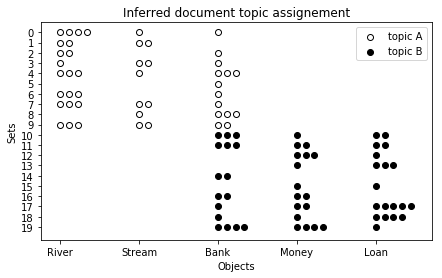

In [8]:
plot_topic_assignment(
    documents_words, 
    documents_word_topics_sampled,
    'Inferred document topic assignement')

In [9]:
# Infer parameters

doc_topic_dist_estim = np.zeros((n_documents, n_topics))
for i in range(n_documents):
    doc_topic_dist_estim[i] = estim_doc_topic_dist(
        i, doc_topic_obs, documents_words, word_prior, n_words_vocab)

topic_word_dist_estim = np.zeros((n_topics, n_words_vocab))
for w in range(n_words_vocab):
    topic_word_dist_estim[:,w] = estim_topic_word_dist(
        w, word_topic_obs, topic_obs, word_prior, n_words_vocab)

### Regenerate from inferred parameters

In [10]:
documents_words_gen = []
documents_word_topics_gen = []
for doc_idx in range(n_documents):
    n_words_doc = int(1 + np.random.poisson(lam=4., size=1))
    doc_topics = np.random.choice(
        a=n_topics, p=doc_topic_dist_estim[doc_idx,:], size=n_words_doc)
    doc_words = [
        np.random.choice(
            a=n_words_vocab, 
            p=topic_word_dist_estim[doc_topics[word_idx], :])
        for word_idx in range(n_words_doc)]
    documents_word_topics_gen.append(doc_topics.tolist())
    documents_words_gen.append(doc_words)

In [ ]:
plot_topic_assignment(
    documents_words_gen, 
    documents_word_topics_gen,
    'Topic assigment of newly generated documents')

## Variational Inference

TODO

* [2.2 Variational Inference for LDA](https://www.cs.cmu.edu/~epxing/Class/10708-14/scribe_notes/scribe_note_lecture15.pdf)
* [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) (paper)